In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import warnings
import pickle
import sys
import json
import neptune

warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')
# import modules
import visualize
import geometry_utils
import dataloader_geo
from maritime_traffic_network import MaritimeTrafficNetwork
import prediction_model_evaluation_metrics as metrics

In [2]:
# path to directory of model
location = 'oslo'
path_format = 'node2node'
filter = 'Passasjer'
directory = '../../models/gretel_prediction_models/'+location+'_passenger/'+path_format+'/'
prediction_task = 'next_nodes'
n_steps = 10
# load metadata from file
with open(directory+'/metadata_'+prediction_task+str(n_steps)+'.json', 'r') as json_file:
    meta_dict = json.load(json_file)
meta_dict

{'network_name': '202208_waypoints_DP10_HDBSCAN20_oslo_full_UTM',
 'n_points': 2173821,
 'n_nodes': 816,
 'n_edges': 3945,
 'training_dates': "['202206', '202207', '202208']",
 'data_version': '',
 'n_training_paths': 2766,
 'node_features': "['n_members', 'speed', 'cog_before', 'cog_after', 'lat', 'lon']",
 'egde_features': "['direction', 'length', 'weight']",
 'path_format': 'node2node',
 'filter': 'Passasjer',
 'lr': 0.0005,
 'loss': 'target_only',
 'n_epochs': 19,
 'target_prediction': 'next',
 'n_walks': 1000,
 'n_start_nodes': 1,
 'n_steps': 10,
 'prediction_task': 'next_nodes',
 'predictions_per_second': 1.705809582451462,
 'model_type': 'Gretel',
 'test_dates': "['202209']",
 'selection_start': 0,
 'selection_end': -1,
 'selection_step': 20,
 'n_test_paths': 1047}

In [3]:
# set parameters for prediction
prediction_task = meta_dict['prediction_task']
eval_mode = 'path'
n_start_nodes= meta_dict['n_start_nodes']
n_steps = meta_dict['n_steps']
network_name = meta_dict['network_name']
test_dates = literal_eval(meta_dict['test_dates'])

In [4]:
# load maritime traffic network
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202208_points_oslo_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 20,
 'clustering_min_cluster_size': 20,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [5]:
# Load test trajectories from file
traj_path_prefix = '../../data/processed/'
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [6]:
# load predictions from file
predictions = pd.read_csv(directory+'/predictions_'+prediction_task+str(n_steps)+'.csv')
predictions['ground_truth'] = predictions['ground_truth'].apply(literal_eval)
predictions['prediction'] = predictions['prediction'].apply(literal_eval)

In [7]:
# check if all predictions are valid
for index, row in predictions.iterrows():
    if geometry_utils.is_valid_path(network.G, row['ground_truth']) == False:
        print(row['mmsi'].tolist())

Evaluating 1047 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.38 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 530.41m
Median SSPD: 145.97m
Mean choice_accuracy: 0.4372


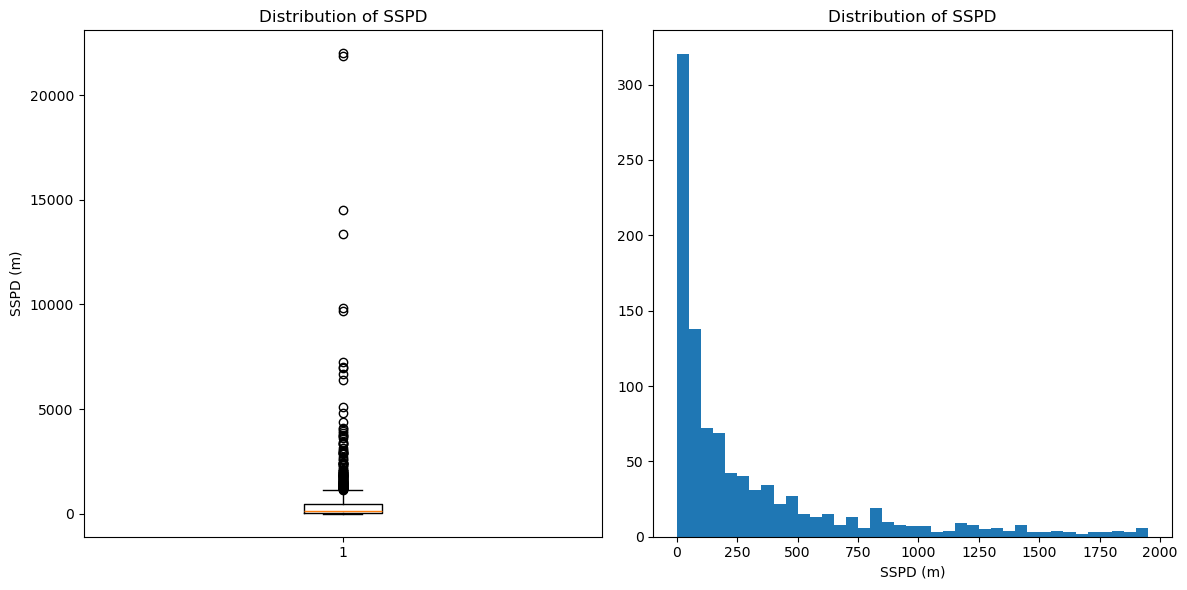

In [8]:
# evaluate
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                                             eval_mode=eval_mode)
nan_mask = evaluation_results.isna().any(axis=1)
failure_rate = nan_mask.sum() / len(evaluation_results)
mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])
choice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])

In [9]:
'''
run = neptune.init_run(
    project="jandrik91/RoutePredictions",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
)  # your credentials

# evaluate
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                                             eval_mode=eval_mode)

nan_mask = evaluation_results.isna().any(axis=1)
failure_rate = nan_mask.sum() / len(evaluation_results)
mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])
choice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])

# save experiment
run["network_name"] = network_name
run["n_points"]=len(network.gdf)
run["n_nodes"]=network.G.number_of_nodes()
run["n_edges"]=network.G.number_of_edges()

params = network.hyperparameters
params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
run["network_parameters"] = params

run["training_data"] = {'training_dates':meta_dict['training_dates'],
                        'n_training_paths':meta_dict['n_training_paths']}

run["test_data"] = {'test_dates':str(test_dates),
                    'selection_start':meta_dict['selection_start'],
                    'selection_end':meta_dict['selection_end'],
                    'selection_step':meta_dict['selection_step'],
                    'n_test_paths':meta_dict['n_test_paths']}

run["prediction_task"] = prediction_task
run["eval_mode"] = eval_mode
run["model_type"] = meta_dict['model_type']
run["n_start_nodes"] = n_start_nodes
run["n_steps"] = n_steps

run['node_features'] = meta_dict['node_features']
run['egde_features'] = meta_dict['egde_features']
run['path_format'] = meta_dict['path_format']
run['lr'] = meta_dict['lr']
run['loss'] = meta_dict['loss']
run['n_epochs'] = meta_dict['n_epochs']
run['MOGen_n_walks'] = meta_dict['n_walks']
run['target_prediction'] = meta_dict['target_prediction']

run["plot"].upload(fig)
run["failure_rate"] = failure_rate
run["mean_abs_err"] = mean_abs_err
run["median_abs_err"] = median_abs_err
run["choice_accuracy"] = choice_accuracy
run["filter"] = filter

run.stop()
'''

'\nrun = neptune.init_run(\n    project="jandrik91/RoutePredictions",\n    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",\n)  # your credentials\n\n# evaluate\nevaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, \n                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, \n                                                             eval_mode=eval_mode)\n\nnan_mask = evaluation_results.isna().any(axis=1)\nfailure_rate = nan_mask.sum() / len(evaluation_results)\nmean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])\nmedian_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])\nchoice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])\n\n# save experiment\nrun["network_name"] = network_name\nrun["n_points"]=len

In [10]:
'''
i = 10
mmsi = evaluation_results['mmsi'].iloc[i]
predictions = {evaluation_results['predicted_path'].iloc[i] : 1}
start_node = [evaluation_results['predicted_path'].iloc[i][0]]
trajectory = test_trajectories.get_trajectory(mmsi)
true_path = evaluation_results['true_path'].iloc[i]
map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location)
map
'''

"\ni = 10\nmmsi = evaluation_results['mmsi'].iloc[i]\npredictions = {evaluation_results['predicted_path'].iloc[i] : 1}\nstart_node = [evaluation_results['predicted_path'].iloc[i][0]]\ntrajectory = test_trajectories.get_trajectory(mmsi)\ntrue_path = evaluation_results['true_path'].iloc[i]\nmap = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, \n                                                min_passages=1, opacity=0.2, location=location)\nmap\n"

In [11]:
evaluation_results

,mmsi,true_path,predicted_path,distances,SSPD,choice_accuracy
0,215610000_0_2022-09-12 04:53:58,"(220, 251, 270, 262, 14, 196, 315, 314, 312, 3...","(220, 557, 559, 564, 567, 568, 571, 572, 13, 4...","[0.0, 393.5274425605377, 787.0548851210754, 11...",13365.379902,0.0
0,215610000_0_2022-09-12 04:53:58,"(449, 465, 475, 472, 491, 497, 10, 294, 279, 2...","(449, 465, 475, 472, 484, 491, 497, 10, 294, 2...","[0.0, 1.1645392786651966e-10, 6.73730562977840...",203.398651,0.7
0,215610000_0_2022-09-12 04:53:58,"(124, 126, 135, 137, 150, 151, 146, 142, 143, ...","(124, 126, 135, 137, 152, 151, 146, 142, 143, ...","[0.0, 5.6375515743101864e-11, 1.12751031486203...",5.801394,0.6
0,215610000_0_2022-09-12 04:53:58,"(479, 476, 481, 383, 408, 393, 463, 493, 512, ...","(479, 476, 481, 432, 383, 394, 409, 408, 393, ...","[0.0, 3.915316034204401e-11, 4.333292313784160...",324.545192,0.4
0,215610000_2_2022-09-13 14:22:04,"(705, 709, 708, 683, 677, 671, 605, 663, 661, ...","(705, 709, 708, 683, 628, 627, 677, 676, 671, ...","[0.0, 6.12359549374496e-11, 9.734805429619208e...",1400.939328,0.3
...,...,...,...,...,...,...
0,578001100_2_2022-09-24 21:43:35,"(497, 498, 10, 295, 294, 279, 280, 306, 305, 2...","(497, 10, 294, 279, 280, 306, 305, 299, 300, 8...","[0.0, 22.80378563917308, 32.5704020392647, 17....",32.625048,0.4
0,578001100_2_2022-09-24 21:43:35,"(143, 144, 147, 148, 4, 125, 0, 130, 131, 120, 5)","(143, 144, 147, 4, 0, 130, 131, 120, 5, 7, 410)","[0.0, 1.0312529911255651e-10, 1.71215185871242...",411.538723,0.6
0,578001100_3_2022-09-25 13:37:21,"(745, 744, 670, 694, 701, 704, 703, 696, 687, ...","(745, 744, 670, 695, 694, 689, 685, 701, 704, ...","[0.0, 4.0674558874115236e-11, 3.07705409593557...",1243.792282,0.5
0,578001100_3_2022-09-25 13:37:21,"(709, 708, 683, 647, 628, 676, 632, 633, 606, ...","(709, 708, 683, 628, 627, 677, 676, 671, 612, ...","[0.0, 4.6372410168108813e-11, 2.83182262909716...",397.267369,0.3


In [12]:
from make_trajectories_from_AIS import add_ship_metadata

# add original mmsi column back to dataframe
evaluation_results.rename(columns={'mmsi':'id'}, inplace=True)
evaluation_results['mmsi'] = evaluation_results['id'].str[:9].astype(int)

# add metadata to each mmsi
meta_file = '../../data/external/seilas-2022.csv'
evaluation_results_meta = add_ship_metadata(meta_file, evaluation_results)

Geopandas has version 0.13.2
Movingpandas has version 0.17.1
Ship metadata has   4142 unique MMSIs
AIS raw data has    30 unique MMSIs
Overlap:            30 MMSIs


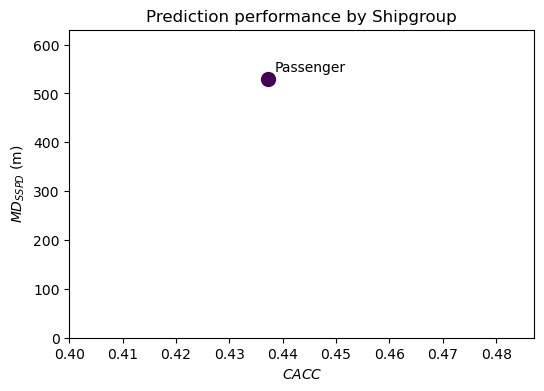

In [13]:
import matplotlib.pyplot as plt

# get choice accuracy and SSPD by shipgroup
sspd_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['SSPD'].mean()
cacc_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['choice_accuracy'].mean()

x = cacc_by_group.values
y = sspd_by_group.values
categories = sspd_by_group.index

fig, ax = plt.subplots(figsize=[6, 4])

# Scatter plot with different colors and markers for each category
scatter = ax.scatter(x, y, c=range(len(categories)), cmap='viridis', marker='o', s=100)

# Annotate each point with the ship category name
for i, category in enumerate(categories):
    ax.annotate(category, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='left')

max_x_value = max(x)
max_y_value = max(y)
ax.set_xlim(0.4, max_x_value+0.05)
ax.set_ylim(0, max_y_value+100)

ax.set_xlabel('$CACC$')
ax.set_ylabel('$MD_{SSPD}$ (m)')
plt.title('Prediction performance by Shipgroup')
plt.savefig('prediction_performance_by_ship_category_tromso_Gretel_3nodes.pdf')

plt.show()

In [14]:
# Count occurrences of each index
index_counts = evaluation_results_meta['skipsgruppe'].value_counts()

# Display the result
print(index_counts)

skipsgruppe
Passenger    1047
Name: count, dtype: int64


In [15]:
sspd_by_group

skipsgruppe
Passenger    530.414969
Name: SSPD, dtype: float64

In [16]:
cacc_by_group

skipsgruppe
Passenger    0.437154
Name: choice_accuracy, dtype: float64